<a href="https://colab.research.google.com/github/KimJisanER/LAIDD/blob/main/molecule_design_%EB%B0%B0%ED%8F%AC%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브 마운트 및 working directory 경로 설정하기
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/denovo/' # change the directory to yours

Mounted at /content/drive


In [2]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 1.2 MB/s 


# 랜덤 시뮬레이션

In [3]:
# building block과 reaction template 불러오기

building_blocks = []
reaction_templates = []
with open(path+"building_blocks.csv") as fin:
    for line in fin:
        if line[0] == '#':
            continue
        content = line.rstrip('\n').split(',')
        smiles = content[1]
        building_blocks.append(smiles)

with open(path+"reaction_templates.tsv") as fin:
    for line in fin:
        if line[0] == '#':
            continue
        content = line.rstrip('\n').split('\t')
        smart = content[1]
        reaction_templates.append(smart)



In [4]:
print(f"the total number of building blocks = {len(building_blocks)}")
print(f"the total number of reaction templates = {len(reaction_templates)}")
print("== sample building blocks ==")
print('\n'.join(building_blocks[0:5]))
print("== sample reaction templates ==")
print('\n'.join(reaction_templates[0:5]))

the total number of building blocks = 100
the total number of reaction templates = 64
== sample building blocks ==
CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C
CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(F)F)cc3)c2)cc1
CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[C@@H](c3ccc(N(C)C)cc3)C[C@@]21C
C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
C#CCC1(C(=O)O)CCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1
== sample reaction templates ==
[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)),C$([CH2](N)(C)):8]-[C$(C(c)(C)(C)(C)),C$([CH](c)(C)(C)),C$([CH2](c)(C)):7]-[c:6]1[cH:1][c:2][c:3][c:4][c:5]1>>[C:10]-1=[N+0:9]-[C:8]-[C:7]-[c:6]2[c:5][c:4][c:3][c:2][c:1]-12
[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$([CH](N)(C)(C)),C$([CH2](N)(C)):8]-[C$([C](c)(C)(C)),C$([CH](c)(C)):7]([O$(OC),OH])-[c:6]1[cH:1][c:2][c:3][c:4][c:5]1>>[c:10]-1[n:9][c:8][c:7][c:6]2[c:5][c:4][c:3][c:2][c:1]-12
[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)),C$([CH2](N)(C)):8]-[C$(C(c)(C)(

In [5]:
# 합성식에서 입력/출력되는 물질의 개수를 확인하는 함수를 정의하자

def count_reactants(reaction_template):
    try:
        split_template = reaction_template.split('>')
        # '>>' 으로 split 하지 않는 이유는 중간 합성이 있는 경우가 있기 때문
        # 예를 들어, A.B>C.D>E
        input_template = split_template[0]
        output_template = split_template[-1]
    except:
        print(reaction_template)
    # 합성식에서 물질은 '.'으로 구분되므로
    input_count = len(input_template.split('.'))
    output_count = len(output_template.split('.'))

    return input_count, output_count


In [6]:
# 입력/출력 물질 개수의 최대값/최소값을 확인해 보자
import numpy as np

max_input, max_output = 0, 0
min_input, min_output = np.inf, np.inf  # np.inf 는 무한대를 의미
for template in reaction_templates:
    num_in, num_out = count_reactants(template)
    max_input = num_in if num_in > max_input else max_input
    max_output = num_out if num_out > max_output else max_output
    min_input = num_in if num_in < min_input else min_input
    min_output = num_out if num_out < min_output else min_output

print(max_input, max_output)
print(min_input, min_output)

# 입력 물질은 최대 2개이고 결과물은 항상 하나 뿐이라는 것을 확인

2 1
1 1


In [13]:
# 주어진 reaction 과 입력 물질들에 대해 sanitized 된 물질을 반환하는 함수
from rdkit import Chem

def get_sanitized_smiles(reaction, blocks):
    sanitized_smiles = []
    all_products = reaction.RunReactants(blocks)
    for product in all_products:
        try:
            [Chem.SanitizeMol(mol) for mol in product]
            smiles = Chem.MolToSmiles(product[0])
            # 왜 product 뒤에 [0] 이 붙는지 생각해 보자
            sanitized_smiles.append(smiles)
        except ValueError:
            continue

    return sanitized_smiles  # sanitization 에 실패했다면 빈 list 반환

In [8]:
# 어떤 화합물 (target_compound) 에 대해
# 가능한 모든 reation_template 과 building_block을 시뮬레이션해서 성공한 product를 반환

import random
from rdkit.Chem import AllChem


def get_simulated_smiles(target_compound, reaction_templates, reactant_blocks):
    # 매번 random 한 template을 가져오기 위해 순서를 섞는다
    simulated_smiles = []
    random.shuffle(reaction_templates)
    for template in reaction_templates:
        num_in, _ = count_reactants(template)  # 입력 물질 개수 확인
        reaction = AllChem.ReactionFromSmarts(template)

        if num_in == 1:
            smiles = get_sanitized_smiles(reaction, (target_compound,))
            if smiles:
                simulated_smiles += smiles

        elif num_in == 2:
            random.shuffle(reactant_blocks)
            for reactant in reactant_blocks:
                smiles = get_sanitized_smiles(reaction, (target_compound, reactant))
                if smiles:
                    simulated_smiles += smiles

    return simulated_smiles  # 그 어떤 반응도 불가능하다면 빈 list 반환

In [14]:
# 초기 구조들을 최대 5번까지 합성을 하는 랜덤 시뮬레이션

from rdkit import Chem


product_pool = set()
selected_products = set() 
reactant_blocks = [Chem.MolFromSmiles(block) for block in building_blocks]
reaction_count = {  # 최대 합성 횟수 저장 dictionary
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
}

max_reaction = 5  # 한 물질 당 최대 5번까지 합성
for block in building_blocks:
    current_block = Chem.MolFromSmiles(block)
    for current_reaction in range(1, max_reaction+1):
        smiles = get_simulated_smiles(
            current_block,
            reaction_templates,
            reactant_blocks,
        )

        if smiles:
            product_pool.update(smiles)
            selected_smiles = smiles[0]
            # 여기서는 random simulation 이므로 첫번째 smiles 선택
            # 최적화를 하고 싶다면 여기서 Best smiles 를 선택
            selected_products.add(selected_smiles)
            current_block = Chem.MolFromSmiles(selected_smiles)

            if current_reaction == max_reaction:
                reaction_count[current_reaction] += 1
        else:
            reaction_count[current_reaction-1] += 1  # 최대 합성 횟수 기록
            break  # 더 이상 합성이 불가능하므로


In [10]:
# 결과를 저장 (product_pool, selected_products, reaction_count)
import os


os.makedirs(path+"result", exist_ok=True)

product_path = path+"result/product_smiles.txt"
selected_path = path+"result/selected_smiles.txt"
count_path = path+"result/reaction_count.txt"

with open(product_path, 'w') as fout:
    fout.write("#SMILES\n")
    for product in product_pool:
        fout.write(product + '\n')

with open(selected_path, 'w') as fout:
    fout.write("#SMILES\n")
    for product in selected_products:
        fout.write(product + '\n')

with open(count_path, 'w') as fout:
    fout.write("#Reaction\tCount\n")
    for key in reaction_count:
        fout.write(f"{key}\t{reaction_count[key]}\n")


# QED 를 최적화하는 방향으로 합성 시뮬레이션
여기서는 여러분이 virtual screening을 통해 찾은 lead의 QED score를 최적화 할 것입니다.

In [11]:
# QED score를 계산하는 함수를 정의

from rdkit import Chem
from rdkit.Chem import QED

def get_QED(smiles):
    mol = Chem.rdmolfiles.MolFromSmiles(smiles)
    qed_value = QED.qed(mol)
    return qed_value

In [12]:
# 초기 구조들을 최대 5번까지 합성을 해서 QED 가 높은 물질 선정

from rdkit import Chem


product_pool = set()
selected_products = set()
reactant_blocks = [Chem.MolFromSmiles(block) for block in building_blocks]
reaction_count = {  # 최대 합성 횟수 저장 dictionary
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
}

max_reaction = 5  # 한 물질 당 최대 5번까지 합성
for block in building_blocks: # change to lead smiles
    current_block = Chem.MolFromSmiles(block)
    initial_qed = get_QED(block)
    for current_reaction in range(1, max_reaction+1):
        smiles = get_simulated_smiles(
            current_block,
            reaction_templates,
            reactant_blocks,
        )
        if smiles:
            product_pool.update(smiles)
            # smiles에 있는 molecule 중에서 가장 QED score가 높은 것을 찾아야 함
            best_qed_score = 0                       ### best_qed_score를 0으로 초기화함
            for smi in smiles:                       ### "smiles"에 대해 for loop를 돌면서,
              current_qed_score = get_QED(smi)       ### smi의 qed score를 계산하고
              if current_qed_score > best_qed_score: ### 만약 smi의 qed score가 best score보다 높다면,
                  best_qed_score = current_qed_score ### best score를 smi의 score로 갱신하고,
                  selected_smiles = smi              ### selected_smiles를 smi로 지정
            if best_qed_score > initial_qed:  # 초기 물질보다 생성된 물질의 QED가 높아진 경우에만 저장한다
                selected_products.add(selected_smiles)
            current_block = Chem.MolFromSmiles(selected_smiles)

            if current_reaction == max_reaction:
                reaction_count[current_reaction] += 1
        else:
            reaction_count[current_reaction-1] += 1  # 최대 합성 횟수 기록
            break  # 더 이상 합성이 불가능하므로

In [15]:
# 결과를 저장 (product_pool, selected_products, reaction_count)
import os


os.makedirs(path+"result_qed", exist_ok=True)

product_path = path+"result_qed/product_smiles.txt"
selected_path = path+"result_qed/selected_smiles.txt"
count_path = path+"result_qed/reaction_count.txt"

with open(product_path, 'w') as fout:
    fout.write("#SMILES\n")
    for product in product_pool:
        fout.write(product + '\n')

with open(selected_path, 'w') as fout:
    fout.write("#SMILES\n")
    for product in selected_products:
        fout.write(product + '\n')

with open(count_path, 'w') as fout:
    fout.write("#Reaction\tCount\n")
    for key in reaction_count:
        fout.write(f"{key}\t{reaction_count[key]}\n")


Mean score of output: 0.2556788351695346
Mean score of input: 0.6130560219067653


(0.0, 1.0)

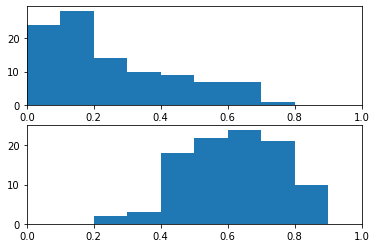

In [16]:
# input molecule과 output molecule의 QED score를 histogram으로 나타내보자.

qed_scores_output = []
qed_scores_input = []
for smi_out, smi_in in zip(selected_products, building_blocks):
    qed_scores_output.append(get_QED(smi_out))
    qed_scores_input.append(get_QED(smi_in))


import matplotlib.pyplot as plt

print(f"Mean score of output: {np.mean(qed_scores_output)}")
print(f"Mean score of input: {np.mean(qed_scores_input)}")
plt.subplot(2,1,1)
plt.hist(qed_scores_output, bins=np.arange(0,1,0.1))
plt.xlim(0,1)
plt.subplot(2,1,2)
plt.hist(qed_scores_input, bins=np.arange(0,1,0.1))
plt.xlim(0,1)

# Target 과의 결합을 최적화하는 방향으로 합성 시뮬레이션

In [17]:
# JAK2 와의 결합을 최적하는 방향으로 합성 시뮬레이션

# 09.29일에 했던 수업과 동일한 방식으로 RandomForest 기반 QSAR 모델을 생성하고 학습함. 
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train QSAR model of JAK2 pIC50 prediction
data = pd.read_csv(path+"JAK2_Chembl.csv")
smiles = data['Smiles']        # Input 값은 SMILES
pic50 = data['pChEMBL Value']

X = []
for i in smiles:
  mol = Chem.MolFromSmiles(i)
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
  fp = np.array(fp)
  X.append(fp)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, pic50, test_size=0.1, random_state=42)

rf_model = RandomForestRegressor() # 빈 모델을 생성
rf_model.fit(X_train, y_train) # Training set 으로 학습을 진행
y_pred = rf_model.predict(X_test) # Test set 의 Feature (ECFP)로 Target value들을 예측
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.7643390394578734


In [18]:
# 학습된 RF-QSAR모델을 이용해 pIC50 예측값을 불러오는 함수를 정의

def get_QSARScore(smiles):
    fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), radius=2, nBits=1024)
    return rf_model.predict([fp])

In [19]:
# 초기 구조들을 최대 5번까지 합성을 해서 QSAR score 가 높은 물질 선정

from rdkit import Chem


product_pool = set()
selected_products = set()
reactant_blocks = [Chem.MolFromSmiles(block) for block in building_blocks]
reaction_count = {  # 최대 합성 횟수 저장 dictionary
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
}

max_reaction = 5  # 한 물질 당 최대 5번까지 합성
for block in building_blocks:
    current_block = Chem.MolFromSmiles(block)
    inital_qsar_score = get_QSARScore(block)
    for current_reaction in range(1, max_reaction+1):
        smiles = get_simulated_smiles(
            current_block,
            reaction_templates,
            reactant_blocks,
        )
        if smiles:
            product_pool.update(smiles)
            best_qsar_score = 0                         ### best_qed_score를 0으로 초기화함
            for smi in smiles:                          ### "smiles"에 대해 for loop를 돌면서,
              current_qsar_score = get_QSARScore(smi)   ### smi의 qsar score를 계산하고
              if current_qsar_score > best_qsar_score:  ### 만약 smi의 qsar score가 best score보다 높다면,
                  best_qsar_score = current_qsar_score  ### best score를 smi의 score로 갱신하고,
                  selected_smiles = smi                 ### selected_smiles를 smi로 지정
            if best_qsar_score > inital_qsar_score:  # QSAR 점수가 초기 구조보다 높으면 저장
                selected_products.add(selected_smiles)
            current_block = Chem.MolFromSmiles(selected_smiles)

            if current_reaction == max_reaction:
                reaction_count[current_reaction] += 1
        else:
            reaction_count[current_reaction-1] += 1  # 최대 합성 횟수 기록
            break  # 더 이상 합성이 불가능하므로

In [20]:
# 결과를 저장 (product_pool, selected_products, reaction_count)
import os


os.makedirs(path+"result_qsar", exist_ok=True)

product_path = path+"result_qsar/product_smiles.txt"
selected_path = path+"result_qsar/selected_smiles.txt"
count_path = path+"result_qsar/reaction_count.txt"

with open(product_path, 'w') as fout:
    fout.write("#SMILES\n")
    for product in product_pool:
        fout.write(product + '\n')

with open(selected_path, 'w') as fout:
    fout.write("#SMILES\n")
    for product in selected_products:
        fout.write(product + '\n')

with open(count_path, 'w') as fout:
    fout.write("#Reaction\tCount\n")
    for key in reaction_count:
        fout.write(f"{key}\t{reaction_count[key]}\n")


Mean score of output: 7.184102580749805
Mean score of input: 6.2380616344201165


(4.0, 10.0)

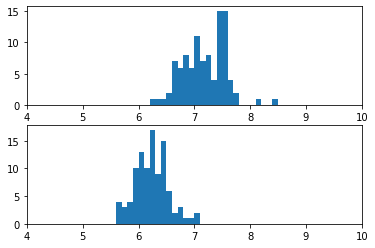

In [21]:
# input molecule과 output molecule의 QSAR score를 histogram으로 나타내보자.

qsar_scores_output = []
qsar_scores_input = []
for smi_out, smi_in in zip(selected_products, building_blocks):
  qsar_scores_output.append(get_QSARScore(smi_out))
  qsar_scores_input.append(get_QSARScore(smi_in))
qsar_scores_output = np.array(qsar_scores_output).flatten()
qsar_scores_input = np.array(qsar_scores_input).flatten()

import matplotlib.pyplot as plt

print(f"Mean score of output: {qsar_scores_output.mean()}")
print(f"Mean score of input: {qsar_scores_input.mean()}")
plt.subplot(2,1,1)
plt.hist(qsar_scores_output, bins=np.arange(4,10,0.1))
plt.xlim(4,10)
plt.subplot(2,1,2)
plt.hist(qsar_scores_input, bins=np.arange(4,10,0.1))
plt.xlim(4,10)

# QED 와 QSAR 를 모두 만족하는 물질 생성

In [22]:
# QSAR 점수의 정규화(normalization)
def NormQSARScore(qsar_score):
    min_score = pic50.min()
    max_score = pic50.max()
    norm_qsar_score = (qsar_score-min_score)/(max_score-min_score)
    return norm_qsar_score

In [23]:
def combined_score(smi):
    return get_QED(smi) * 0.5 + NormQSARScore(get_QSARScore(smi)) * 0.5

In [24]:
# 초기 구조들을 최대 5번까지 합성을 해서 QED와 QSAR 가 높은 물질 선정
from rdkit import Chem


product_pool = set()
selected_products = set()
reactant_blocks = [Chem.MolFromSmiles(block) for block in building_blocks]
reaction_count = {  # 최대 합성 횟수 저장 dictionary
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
}

max_reaction = 5  # 한 물질 당 최대 5번까지 합성
for block in building_blocks:
    current_block = Chem.MolFromSmiles(block)
    initial_score = combined_score(block)
    for current_reaction in range(1, max_reaction+1):
        smiles = get_simulated_smiles(
            current_block,
            reaction_templates,
            reactant_blocks,
        )
        if smiles:
            product_pool.update(smiles)               
            best_score = 0                                      ### best_qed_score를 0으로 초기화함
            for smi in smiles:                                  ### "smiles"에 대해 for loop를 돌면서,
              current_score = combined_score(smi)   ### smi의 (QED+QSAR) score를 계산하고
              if current_score > best_score:                    ### 만약 smi의 score가 best score보다 높다면,
                  best_score = current_score                    ### best score를 smi의 score로 갱신하고,
                  selected_smiles = smi                         ### selected_smiles를 smi로 지정
            if best_score > initial_score:
                selected_products.add(selected_smiles)
            current_block = Chem.MolFromSmiles(selected_smiles)

            if current_reaction == max_reaction:
                reaction_count[current_reaction] += 1
        else:
            reaction_count[current_reaction-1] += 1  # 최대 합성 횟수 기록
            break  # 더 이상 합성이 불가능하므로

In [25]:
# 결과를 저장 (product_pool, selected_products, reaction_count)
import os


os.makedirs(path+"result_qed_qsar", exist_ok=True)

product_path = path+"result_qed_qsar/product_smiles.txt"
selected_path = path+"result_qed_qsar/selected_smiles.txt"
count_path = path+"result_qed_qsar/reaction_count.txt"

with open(product_path, 'w') as fout:
    fout.write("#SMILES\n")
    for product in product_pool:
        fout.write(product + '\n')

with open(selected_path, 'w') as fout:
    fout.write("#SMILES\n")
    for product in selected_products:
        fout.write(product + '\n')

with open(count_path, 'w') as fout:
    fout.write("#Reaction\tCount\n")
    for key in reaction_count:
        fout.write(f"{key}\t{reaction_count[key]}\n")


Mean score of output: 6.669661445367957
Mean score of input: 6.224537785335537


(4.0, 10.0)

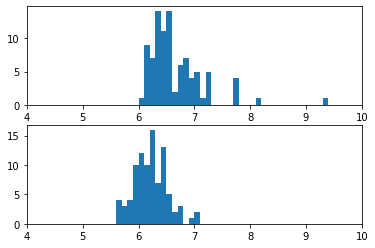

In [26]:
# 합성 전후 QSAR score 분포 확인

import matplotlib.pyplot as plt

qsar_scores_output = []
qsar_scores_input = []
for smi_out, smi_in in zip(selected_products, building_blocks):
  qsar_scores_output.append(get_QSARScore(smi_out))
  qsar_scores_input.append(get_QSARScore(smi_in))
qsar_scores_output = np.array(qsar_scores_output)
qsar_scores_input = np.array(qsar_scores_input)

print(f"Mean score of output: {qsar_scores_output.mean()}")
print(f"Mean score of input: {qsar_scores_input.mean()}")
plt.subplot(2,1,1)
plt.hist(qsar_scores_output, bins=np.arange(4,10,0.1))
plt.xlim(4,10)
plt.subplot(2,1,2)
plt.hist(qsar_scores_input, bins=np.arange(4,10,0.1))
plt.xlim(4,10)

Mean score of output: 0.6483381924275124
Mean score of input: 0.6117703184290393


(0.0, 1.0)

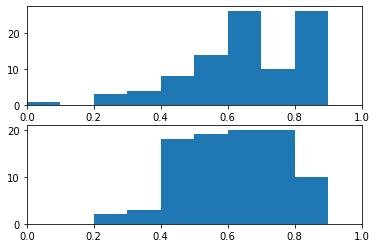

In [27]:
# 합성 전후 QED score 분포 확인

import matplotlib.pyplot as plt

qed_scores_output = []
qed_scores_input = []
for smi_out, smi_in in zip(selected_products, building_blocks):
    qed_scores_output.append(get_QED(smi_out))
    qed_scores_input.append(get_QED(smi_in))

print(f"Mean score of output: {np.mean(qed_scores_output)}")
print(f"Mean score of input: {np.mean(qed_scores_input)}")
plt.subplot(2,1,1)
plt.hist(qed_scores_output, bins=np.arange(0,1,0.1))
plt.xlim(0,1)
plt.subplot(2,1,2)
plt.hist(qed_scores_input, bins=np.arange(0,1,0.1))
plt.xlim(0,1)

# 주어진 smiles file을 초기구조로 사용해서 표적 결합력을 최적화

In [29]:
# def get_QSARScore(smiles): <- 이미 만들어둔 QSAR score 함수를 사용하자
def get_QSARScore(smiles):
    fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), radius=2, nBits=1024)
    return rf_model.predict([fp])

from rdkit import Chem

with open(path+'vs_result3.csv') as f:
  vs_molecules = f.read().splitlines()

initial_blocks = vs_molecules #4 Load SMILES list of pre-defined molecules

product_pool = set()
selected_products = set()
reactant_blocks = [Chem.MolFromSmiles(block) for block in building_blocks]
reaction_count = {  # 최대 합성 횟수 저장 dictionary
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
}

max_reaction = 5  # 한 물질 당 최대 5번까지 합성
for block in initial_blocks:  # building blocks 대신 초기물질로 inital_blocks 사용
    current_block = Chem.MolFromSmiles(block)
    inital_qsar_score = get_QSARScore(block)
    for current_reaction in range(1, max_reaction+1):
        smiles = get_simulated_smiles(
            current_block,
            reaction_templates,
            reactant_blocks,
        )
        if smiles:
            product_pool.update(smiles)
            best_qsar_score = 0                         ### best_qed_score를 0으로 초기화함
            for smi in smiles:                          ### "smiles"에 대해 for loop를 돌면서,
              current_qsar_score = get_QSARScore(smi)   ### smi의 qsar score를 계산하고
              if current_qsar_score > best_qsar_score:  ### 만약 smi의 qsar score가 best score보다 높다면,
                  best_qsar_score = current_qsar_score  ### best score를 smi의 score로 갱신하고,
                  selected_smiles = smi                 ### selected_smiles를 smi로 지정
            if best_qsar_score > inital_qsar_score:  # QSAR 점수가 초기 구조보다 높으면 저장
                selected_products.add(selected_smiles)
            current_block = Chem.MolFromSmiles(selected_smiles)

            if current_reaction == max_reaction:
                reaction_count[current_reaction] += 1
        else:
            reaction_count[current_reaction-1] += 1  # 최대 합성 횟수 기록
            break  # 더 이상 합성이 불가능하므로

Mean score of output: 7.774391608986813
Mean score of input: 7.34787571930926


(4.0, 10.0)

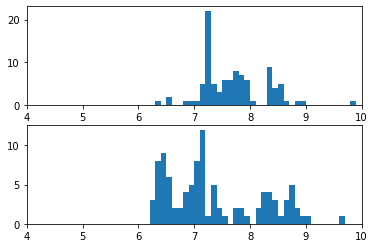

In [30]:
# 전후의 QSAR score를 비교

import matplotlib.pyplot as plt

qsar_scores_output = []
qsar_scores_input = []
for smi_out, smi_in in zip(selected_products, initial_blocks):
  qsar_scores_output.append(get_QSARScore(smi_out))
  qsar_scores_input.append(get_QSARScore(smi_in))
qsar_scores_output = np.array(qsar_scores_output)
qsar_scores_input = np.array(qsar_scores_input)

print(f"Mean score of output: {qsar_scores_output.mean()}")
print(f"Mean score of input: {qsar_scores_input.mean()}")
plt.subplot(2,1,1)
plt.hist(qsar_scores_output, bins=np.arange(4,10,0.1))
plt.xlim(4,10)
plt.subplot(2,1,2)
plt.hist(qsar_scores_input, bins=np.arange(4,10,0.1))
plt.xlim(4,10)

### Final project: QED, DLscore, QSAR 의 가중치를 달리해서 합성해 보자
### Hint: new score = (QED * 0.3 + DLscore * 0.2 + QSAR * 0.5)

In [31]:
# Druglike-molecules 섹션에서 개발한 Random Forest 모델을 활용 (DLscore)
# Sess 2 (Druglike_molecules.ipynb 에서 학습한 classifier (DL_model.pickle)을 불러오기
import pickle
from sklearn.ensemble import RandomForestClassifier

dl_model = RandomForestClassifier(n_estimators=100)
with open(path + 'DL_model.pickle', 'rb') as frb:
  dl_model = pickle.load(frb)

In [32]:
# 위에서 배운 내용을 토대로, new score를 최적화하는 모델 만들기

Mean score of output: 7.774391608986813
Mean score of input: 6.2380616344201165


(4.0, 10.0)

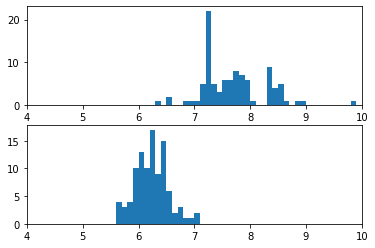

In [33]:
# 전후의 QSAR score를 비교

import matplotlib.pyplot as plt

qsar_scores_output = []
qsar_scores_input = []
for smi_out, smi_in in zip(selected_products, building_blocks):
  qsar_scores_output.append(get_QSARScore(smi_out))
  qsar_scores_input.append(get_QSARScore(smi_in))
qsar_scores_output = np.array(qsar_scores_output)
qsar_scores_input = np.array(qsar_scores_input)

print(f"Mean score of output: {qsar_scores_output.mean()}")
print(f"Mean score of input: {qsar_scores_input.mean()}")
plt.subplot(2,1,1)
plt.hist(qsar_scores_output, bins=np.arange(4,10,0.1))
plt.xlim(4,10)
plt.subplot(2,1,2)
plt.hist(qsar_scores_input, bins=np.arange(4,10,0.1))
plt.xlim(4,10)

Mean score of output: 0.17674869237801222
Mean score of input: 0.6130560219067653


(0.0, 1.0)

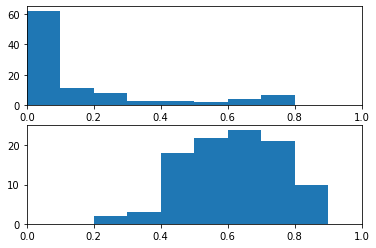

In [34]:
# 전후의 QED score를 비교

import matplotlib.pyplot as plt

qed_scores_output = []
qed_scores_input = []
for smi_out, smi_in in zip(selected_products, building_blocks):
    qed_scores_output.append(get_QED(smi_out))
    qed_scores_input.append(get_QED(smi_in))

print(f"Mean score of output: {np.mean(qed_scores_output)}")
print(f"Mean score of input: {np.mean(qed_scores_input)}")
plt.subplot(2,1,1)
plt.hist(qed_scores_output, bins=np.arange(0,1,0.1))
plt.xlim(0,1)
plt.subplot(2,1,2)
plt.hist(qed_scores_input, bins=np.arange(0,1,0.1))
plt.xlim(0,1)